In [ ]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 19.0 MB/s eta 0:00:00


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 23 13:59:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install imblearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[########################################] | 100% Completed | 348.37 s
Distribuição das classes antes do balanceamento:
label
ABG    804514
CG     800622
AC     800436
ACG    800346
AB     800309
AG     800303
BG     800111
BCG    799807
BC     799749
ABC    795403
Name: count, dtype: int64[pyarrow]
Distribuição das classes após o balanceamento:
label
AB     804514
ABC    804514
ACG    804514
BCG    804514
BG     804514
AC     804514
BC     804514
ABG    804514
AG     804514
CG     804514
Name: count, dtype: int64[pyarrow]

Modelo: KNN
Acurácia Média: 0.8105029868964367
Precisão Média: 0.8242389993490102
Recall Médio: 0.8105029868964367
F1-Score Médio: 0.8139833402441727


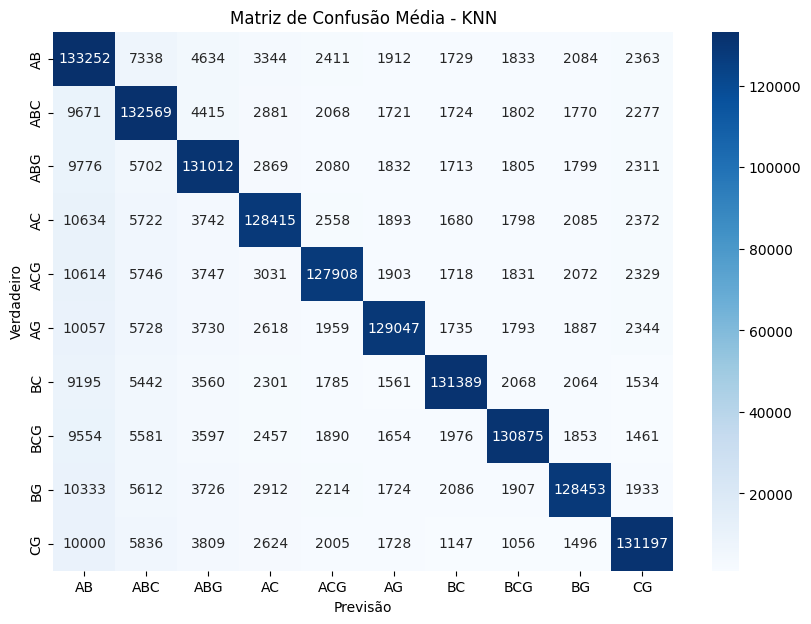

Tempo de treinamento total: 1346.1982984542847 segundos

Avaliação no Conjunto de Teste:
Acurácia: 0.8103994201159768
Precisão: 0.8240922977350044
Recall: 0.8103994201159768
F1-Score: 0.8138754449586675


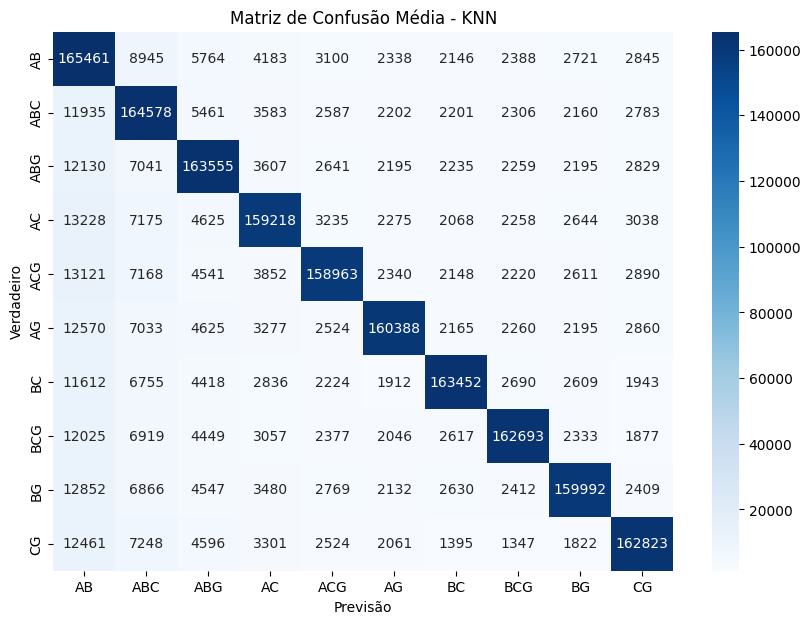

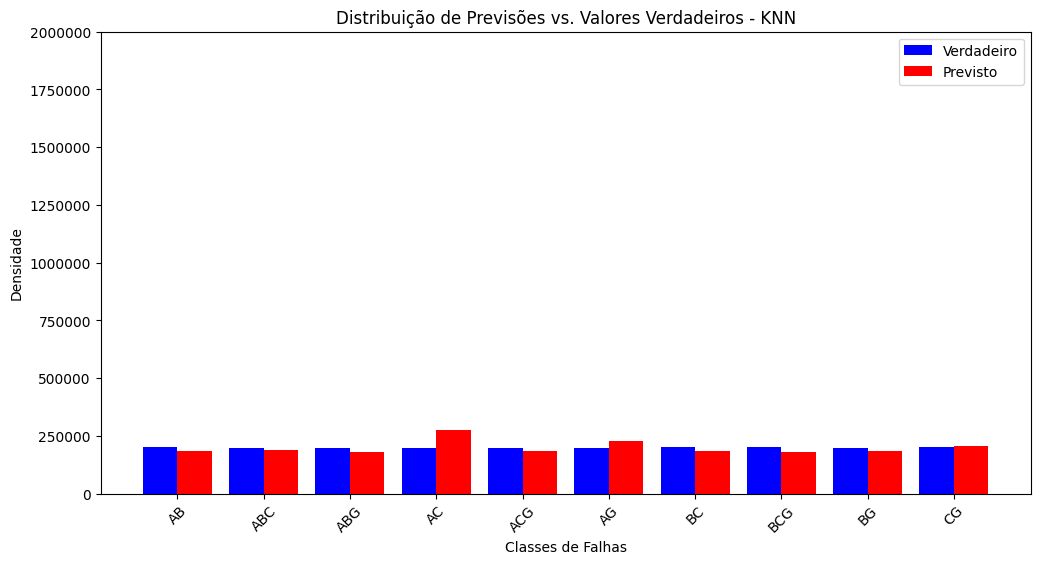

In [ ]:
import os
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar e pré-processar os dados usando Dask, removendo espaços em branco e duplicatas
def process_data(filepath, cols_to_use):
    df = dd.read_csv(filepath, usecols=cols_to_use)
    df = df.drop_duplicates().fillna(df.mean())
    df = df.map_partitions(lambda x: x.apply(lambda col: col.str.strip() if col.dtype == "object" else col))
    return df

# Função para adicionar rótulos
def add_labels(df, label):
    df['label'] = label
    return df

# Função para processar arquivos em uma pasta
def process_files_in_folder(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if files:
        dfs = [process_data(file, cols_to_use) for file in files]
        df = dd.concat(dfs, axis=0)
        df = df.map_partitions(lambda df_partition: add_labels(df_partition, label))
        return df
    else:
        print(f"No CSV files found in {folder_path}")
        return None

# Função para processar todas as pastas e realizar a divisão de dados
def prepare_and_split_data(base_path, subfolders):
    folder_dfs = []
    for subfolder in subfolders:
        folder_path = os.path.join(base_path, subfolder)
        df = process_files_in_folder(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                    'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                    'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], subfolder)
        if df is not None:
            folder_dfs.append(df)

    if folder_dfs:
        final_df = dd.concat(folder_dfs, axis=0).compute()
        X = final_df.drop('label', axis=1)
        y = final_df['label']
        return train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        return None, None, None, None

base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

with ProgressBar():
    X_train, X_test, y_train, y_test = prepare_and_split_data(base_path, subfolders)

# Normalização apenas nos dados de treinamento
scaler = DaskScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balanceamento SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Imprimindo informações sobre o balanceamento
print("Distribuição das classes antes do balanceamento:")
print(y_train.value_counts())
print("Distribuição das classes após o balanceamento:")
print(pd.Series(y_train_resampled).value_counts())

# Validação cruzada e treinamento do modelo kNN
knn_model = KNeighborsClassifier(n_neighbors=5)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

start_time = time.time()
for train_index, test_index in kf.split(X_train_resampled):
    X_fold_train, X_fold_test = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
    y_fold_train, y_fold_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]

    # Treinamento do modelo
    knn_model.fit(X_fold_train, y_fold_train)

    y_fold_pred = knn_model.predict(X_fold_test)
    accuracies.append(accuracy_score(y_fold_test, y_fold_pred))
    precision, recall, fscore, _ = precision_recall_fscore_support(y_fold_test, y_fold_pred, average='weighted')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(fscore)
    conf_matrices.append(confusion_matrix(y_fold_test, y_fold_pred))

# Cálculo das médias das métricas
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)

# Exibindo métricas
print(f"\nModelo: KNN")
print(f"Acurácia Média: {mean_accuracy}")
print(f"Precisão Média: {mean_precision}")
print(f"Recall Médio: {mean_recall}")
print(f"F1-Score Médio: {mean_f1_score}")

# Funções para plotar a matriz de confusão
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão Média - KNN')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()

labels = np.unique(np.concatenate((y_train_resampled, y_test)))
plot_confusion_matrix(mean_conf_matrix, labels=labels)

# Treinamento final do modelo e avaliação no conjunto de teste
knn_model.fit(X_train_resampled, y_train_resampled)
training_time = time.time() - start_time
print(f"Tempo de treinamento total: {training_time} segundos")

y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibindo métricas do conjunto de teste
print(f"\nAvaliação no Conjunto de Teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")

# Função para plotar a matriz de confusão e histograma
def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    categories = np.unique(np.concatenate((y_test, y_pred)))
    bins = np.arange(len(categories) + 1) - 0.5
    plt.hist([y_test, y_pred], bins=bins, color=['blue', 'red'], label=['Verdadeiro', 'Previsto'], align='mid', rwidth=0.8)
    plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    plt.title('Distribuição de Previsões vs. Valores Verdadeiros - KNN')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.ylim(0, 2000000)  # Ajusta o limite do eixo y
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend()
    plt.show()

labels = np.unique(np.concatenate((y_train_resampled, y_test)))
plot_confusion_matrix(conf_matrix, labels=labels)
plot_predictions_vs_true(y_test, y_pred)


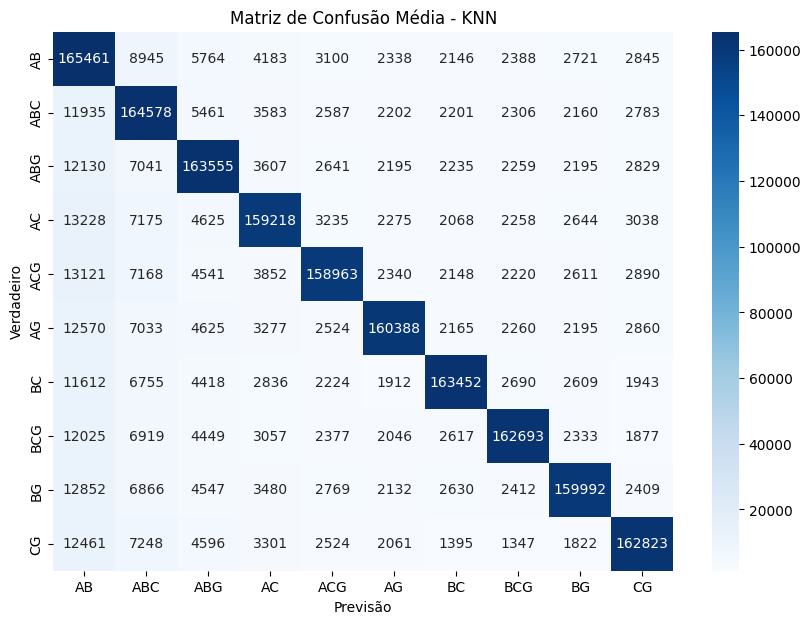

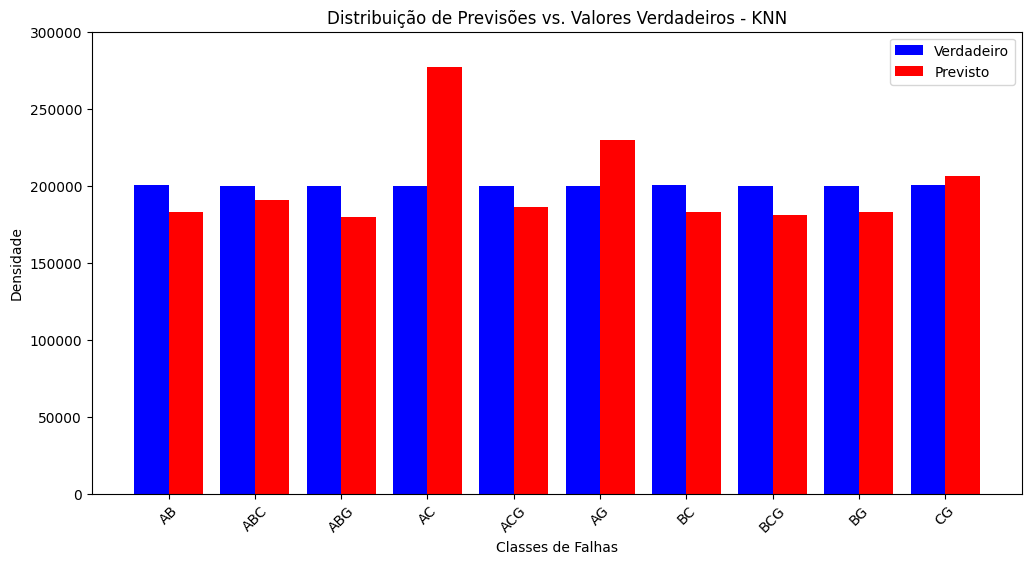

In [ ]:

def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    categories = np.unique(np.concatenate((y_test, y_pred)))
    bins = np.arange(len(categories) + 1) - 0.5
    plt.hist([y_test, y_pred], bins=bins, color=['blue', 'red'], label=['Verdadeiro', 'Previsto'], align='mid', rwidth=0.8)
    plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    plt.title('Distribuição de Previsões vs. Valores Verdadeiros - KNN')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.ylim(0, 300000)  # Ajusta o limite do eixo y
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend()
    plt.show()


labels = np.unique(np.concatenate((y_train_resampled, y_test)))
plot_confusion_matrix(conf_matrix, labels=labels)
plot_predictions_vs_true(y_test, y_pred)